# Process 202405-2xrez Bathymetry

Based on `tools/bathymetry/Process202108Bathymetry.ipynb` notebook.

Base bathymetry was created in the
https://github.com/SalishSeaCast/analysis-doug/blob/main/notebooks/2xrez-202111/bathymetry-202405-2xrez.ipynb
notebook by following Michael's process.
Its major differences from the double resolution 202207j bathymetry are:
* Changed the Pitt River to be a short, closed stub
* Changed the proxy Fraser River extension to go southward instead of northward,
  and to start just east of the mouth of the Pitt River instead of from the Pitt

Processing steps:
1. Straighten Channel at North Open Boundary
2. Straighten Channel at West Open Boundary
3. Adjust Specific Grid Cells
4. Smooth
5. Add Steeveston Jetty
6. Check dredged Fraser River Channel
7. Plot the Final Bathymetry
8. Write out bathy file and jetty extra friction files


The conda environment file for this notebook is `environment-2xrez.yaml`.

In [1]:
from pathlib import Path
import sys

import arrow
import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from salishsea_tools import bathy_tools, viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]'
numpy.__version__='2.3.1'
xarray.__version__='2025.6.1'
bottleneck.__version__='1.5.0'
pandas.__version__='2.3.0'
h5netcdf.__version__='1.6.3'
h5py.__version__='3.14.0'
netCDF4.__version__='1.7.2'
scipy.__version__='1.16.0'
matplotlib.__version__='3.10.3'
cmocean.__version__='v3.0.3'
arrow.__version__='1.3.0'


## Load, Plot and `depth_check()` the Bathymetry

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")
repos_prefix = repos_prefix if repos_prefix.exists() else Path("/data/dlatorne/MEOPAR/")

In [4]:
bathy_paths = {
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_final_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["dbl_202405"], engine='h5netcdf') as bathy:
    lons = bathy.nav_lon
    lats = bathy.nav_lat
    base_bathy = bathy.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

Plotting setup:

In [7]:
cmap = cm.deep
cmap.set_bad('darkgreen')
lon_limits = (47, 51)
lat_limits = (-126.3, -122.2)
y_max = base_bathy.y.max().item() + 1
x_max = base_bathy.x.max().item() + 1
cNorm  = matcolors.Normalize(vmin=0, vmax=14)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='cool')

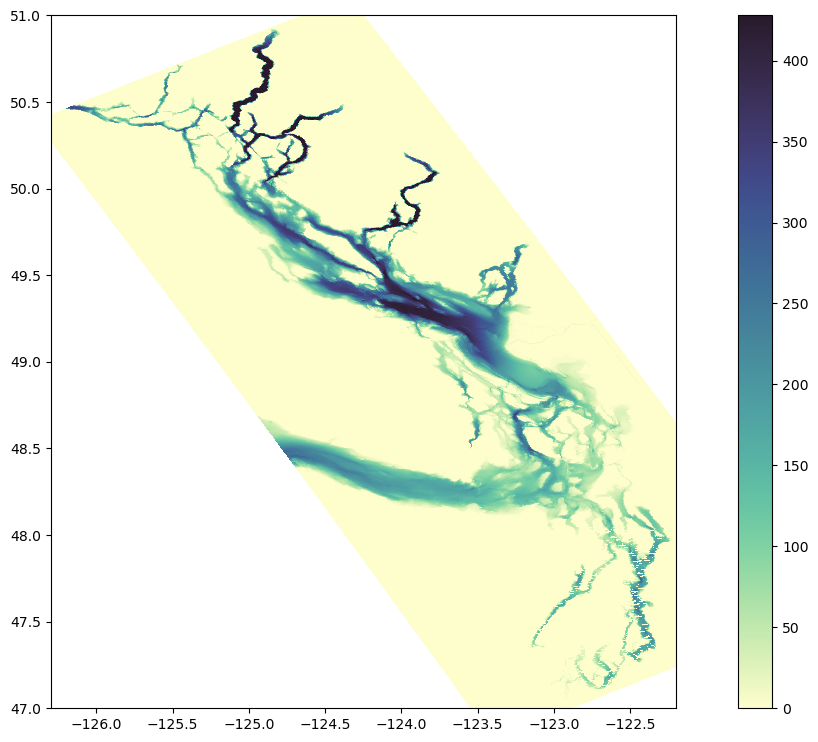

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lons_e, lats_e, base_bathy, cmap=cmap)
fig.colorbar(mesh, ax=ax);

In [9]:
def depth_check(bathy):
    """Checks the depth at each point of the bathymetric data and prints
    whether it is "Deep" or "Shallow".

    A depth greater than 428 is considered "Deep" and a depth between 0
    and 4 (non-inclusive) is considered "Shallow". The function iterates
    through the entire 2D array of bathymetric data to classify each point.

    :param bathy: 2D array of bathymetric data where each element represents
                  the depth at that point
    :type bathy: numpy.ndarray

    :return: None
    """
    DEEP_DEPTH_THRESHOLD = 428
    SHALLOW_DEPTH_UPPER_THRESHOLD = 4
    SHALLOW_DEPTH_LOWER_THRESHOLD = 0

    # Utility function to encapsulate repeating depth info printing
    def print_depth_info(mask, label, base_bathy):
        for y in mask.y:
            for x in mask.x:
                if mask[y, x]:
                    print(
                        f"{label}: y={y.item()}, x={x.item()}, depth={base_bathy[y, x].item()}"
                    )

    # Identify deep and shallow areas
    deep_mask = bathy > DEEP_DEPTH_THRESHOLD
    shallow_mask = numpy.logical_and(
        base_bathy < SHALLOW_DEPTH_UPPER_THRESHOLD,
        base_bathy > SHALLOW_DEPTH_LOWER_THRESHOLD
    )

    # Handle deep areas
    if deep_mask.any():
        print_depth_info(deep_mask, "Deep", base_bathy)

    # Handle shallow areas
    if shallow_mask.any():
        print_depth_info(shallow_mask, "Shallow", base_bathy)


In [10]:
depth_check(base_bathy)

## Straighten Channel at North Open Boundary

Change the shape of Johnstone Strait at the north boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [11]:
ns_bathy = base_bathy.copy()
js = 70  # x index to start changes at
je = 120  # x index to end changes at

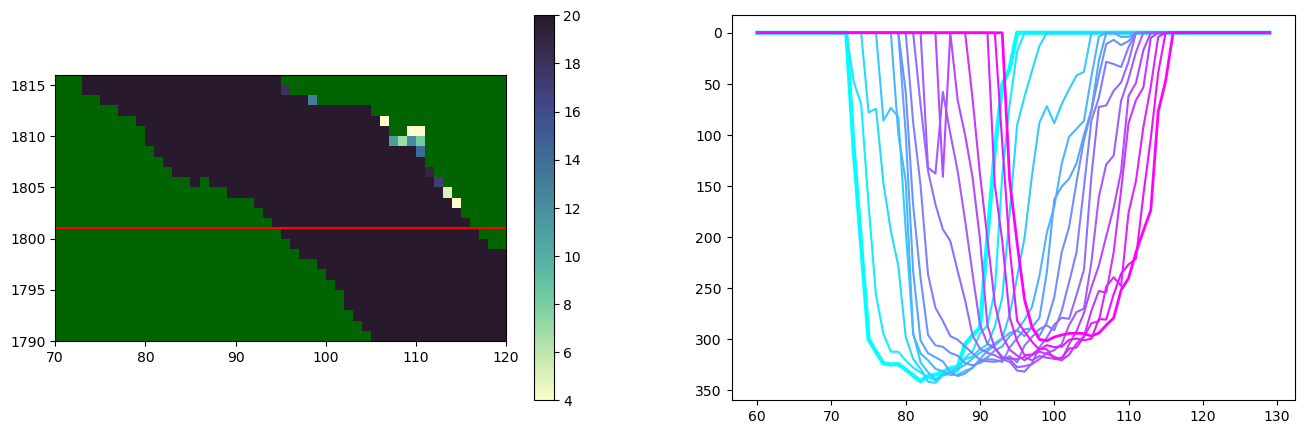

In [12]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)


def plot_north_bdy(ns_masked, y_max):
    fig, (ax_plan, ax_depth) = plt.subplots(1, 2, figsize=(16, 5))
    ax_plan.set_ylim((1790, y_max))
    ax_plan.set_xlim((70, 120))
    ax_plan.plot([70, 120], [y_max-15, y_max-15], 'r-')

    viz_tools.set_aspect(ax_plan)
    mesh = ax_plan.pcolormesh(ns_masked, cmap=cmap, vmax=20)
    fig.colorbar(mesh, ax=ax_plan)
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1, js - 10:je + 10],
                  color=scalarMap.to_rgba(0), linewidth=3)
    for i in range(1, 14):
        ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - i, js - 10:je + 10],
                      color=scalarMap.to_rgba(i))
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - 14, js - 10:je + 10],
                  color=scalarMap.to_rgba(14), linewidth=2)
    ax_depth.invert_yaxis()


plot_north_bdy(ns_masked, y_max)

In [13]:
# Take the nice smooth curve at the boundary and blend it into the nice smooth curve at 15 which is ss=21 steps west
# TOO perfect, so add in some of the variation in the real bathymetry (after keep)
init_north = np.array(base_bathy[y_max-1, :])
init_15 = np.array(base_bathy[y_max-15, :])
ss = 21
# first six rows are straight, shifted add to the east
add = 10
strat = 6
for ii in range(y_max-strat, y_max):
    ns_bathy[ii, js:je] = init_north[js-add:je-add]
# now blend into the bathymetry at 15 shifting 2 or 3 (average 2.4) east as we go
keep = strat+5
for ii in range(strat, keep):
    row = y_max - 1 - ii # row where we are putting the new bathymetry
    jj = ii - strat # weighting as we move down
    shift = int(jj*1.3) + add # how far we shift
    ns_bathy[row, js+shift:je+shift] = (((10-jj) * init_north[js:je] + jj * init_15[js+ss:je+ss]))/10.
for ii in range(keep, 15+1):
    row = y_max - 1 - ii # row where we are putting the new bathymetry
    jj = ii - strat # weighting as we move down
    shift = int(jj*1.3) + add # how far we shift
    ns_bathy[row, js+shift:je+shift] = np.maximum((((10-jj) * init_north[js:je] + jj * init_15[js+ss:je+ss]))/10., base_bathy[row, js+shift:je+shift])

10
11
12
13
15
16
17
19
20
21


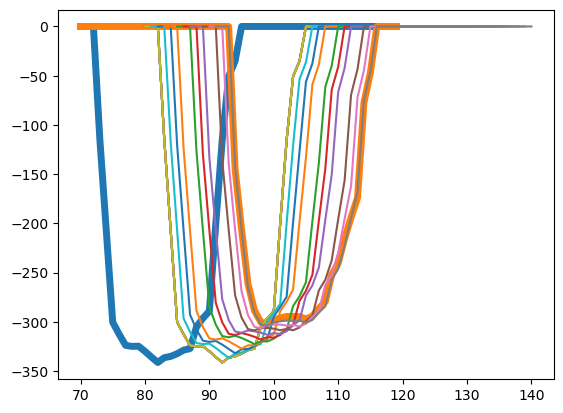

In [14]:
# Cell to perfect the shifting and blending
plt.plot(range(js, je), np.array(-base_bathy[y_max-1, js:je]), linewidth=5)
add = 10
strat = 6
ss = 21
plt.plot(range(js, je), np.array(-base_bathy[y_max-15, js:je]), linewidth=5)
for ii in range(strat):
    plt.plot(range(js+add, je+add), np.array(-base_bathy[y_max-1, js:je]))
for ii in range(strat, 15+1):
    jj = ii - strat
    shift = int(jj*1.3) + add
    print (shift)
    plt.plot(range(js+shift, je+shift), (((10-jj)*np.array(-base_bathy[y_max-1, js:je]) + jj*np.array(-base_bathy[y_max-15, js+ss:je+ss]))/10.))

In [15]:
# Remove shallow points, deepen points almost at 4
for i in range(1800,y_max):
    for j in range(70, 120) :
        if ns_bathy[i, j] < 2:
            ns_bathy[i, j] = 0
        elif ns_bathy[i, j] < 4:
            ns_bathy[i, j] = 4

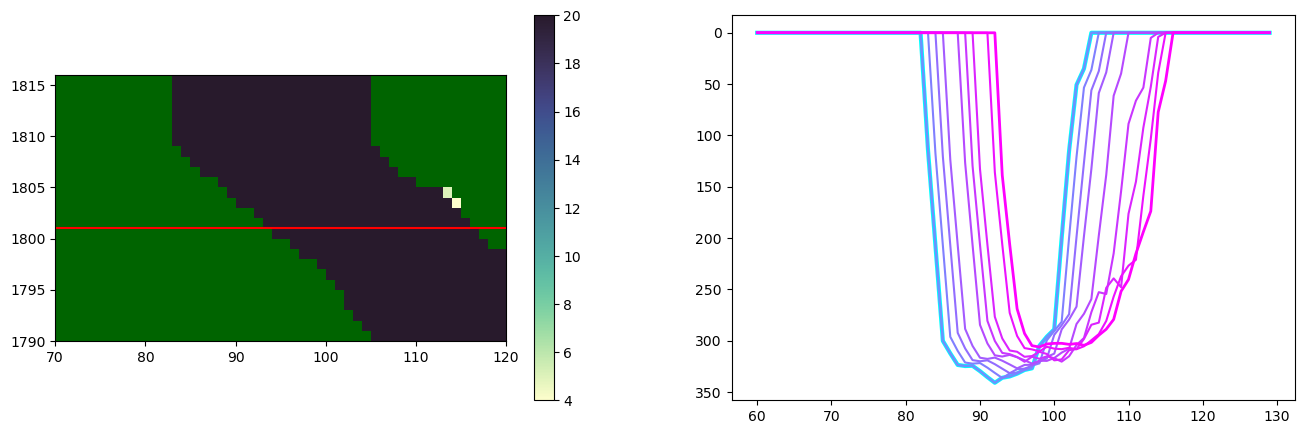

In [16]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)
plot_north_bdy(ns_masked, y_max)

depth_check(ns_masked)

## Straighten Channel at West Open Boundary

Change the shape of Jua de Fuca Strait at the west boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

**TODO** with lots of help from Susan...

In [27]:
ws_bathy = ns_bathy.copy()
iss = 350*2 + 10*2
iee = 470*2 + 10*2

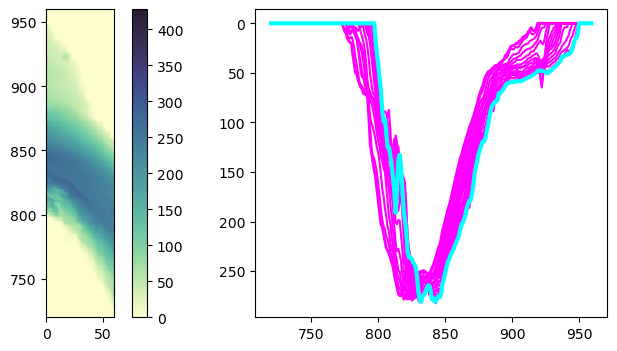

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_bathy, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((iss, iee))
axs[0].set_xlim((0, 30*2));

for j in range(1, 14*2, 2):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14*2], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()

Unlike the North, the mouth profile is kind of jagged.   
A. We'll take out the bank to the south by rearranging the profile and   
B. We'll rearrange the depths in the centre, so that they are a simple up and down: i.e. make the two deep channels into one. At the same time, move the deepest point, one point to the south. This emphasizes the southern channel, which is the channel that continues into Juan de Fuca. We do this so there is no artifical sill in this channel which is not seen in the original bathymetry.

[110.70277659 125.09666443 125.26741664 132.94555664 143.28166707
 155.54082743 169.2851944  191.03959147 169.50092061 137.13750203
 132.64415995 144.13612366 166.79582214 188.32392629 198.86112722
 211.51165517 231.05262756 236.2228953  236.28281148 237.30971018]


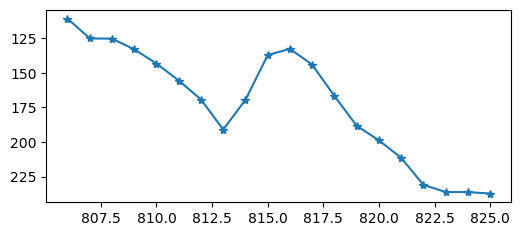

In [93]:
core = np.copy(ws_bathy[:, 0])
print (core[iss+43*2:iss+53*2])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+43*2, iss+53*2), ws_bathy[iss+43*2:iss+53*2, 0], '-*')
ax.invert_yaxis();

[110.70277659 125.09666443 125.26741664 132.64415995 132.94555664
 137.13750203 143.28166707 144.13612366 155.54082743 166.79582214
 169.2851944  169.50092061 188.32392629 191.03959147 198.86112722
 211.51165517 231.05262756 236.2228953  236.28281148 237.30971018]


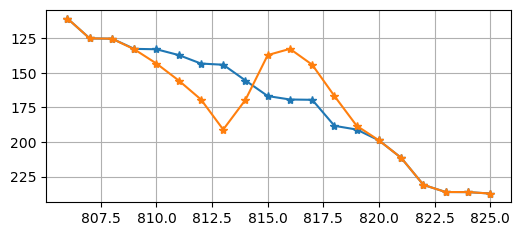

In [94]:
# A. remove bank
core[809] = ws_bathy[816, 0]
core[810] = ws_bathy[809, 0]
core[811] = ws_bathy[815, 0]
core[812] = ws_bathy[810, 0]
core[813] = ws_bathy[817, 0]
core[814] = ws_bathy[811, 0]
core[815] = ws_bathy[818, 0]
core[816] = ws_bathy[812, 0]
core[817] = ws_bathy[814, 0]
core[818] = ws_bathy[819, 0]
core[819] = ws_bathy[813, 0]
print (core[iss+43*2:iss+53*2])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+43*2, iss+53*2), core[iss+43*2:iss+53*2], '*-')
ax.plot(np.arange(iss+43*2, iss+53*2), ws_bathy[iss+43*2:iss+53*2, 0], '-*')
ax.invert_yaxis();
ax.grid()

[236.28281148 237.30971018 240.93969727 242.94869995 246.28077952
 257.44332886 270.63043213 279.88183594 280.97012838 275.39338684
 274.03349304 272.16280111 268.12557983 264.75882467 264.37724813
 268.90191142 278.21409607 277.29577128 280.6583964  280.66595459
 276.80905151 274.74803162 276.52190653 272.08627319 263.05193075
 257.26968892 251.01481883 245.70648448 240.70204163 237.67063904]


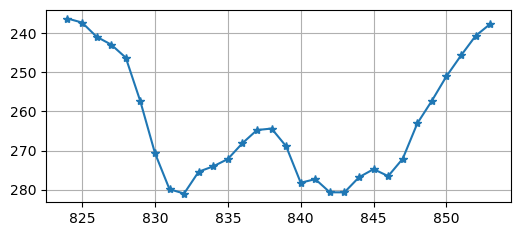

In [95]:
nis, nie = 402*2+20, 417*2+20
print (ws_bathy[nis:nie, 0].values)
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(nis, nie), ws_bathy[nis:nie, 0], '-*')
ax.invert_yaxis();
ax.grid();

[236.28281148 237.30971018 240.93969727 242.94869995 246.28077952
 257.44332886 270.63043213 280.97012838 280.66595459 280.6583964
 279.88183594 278.21409607 277.29577128 276.80905151 276.52190653
 275.39338684 274.74803162 274.03349304 272.16280111 272.08627319
 268.90191142 268.12557983 264.75882467 264.37724813 263.05193075
 257.26968892 251.01481883 245.70648448 240.70204163 237.67063904]


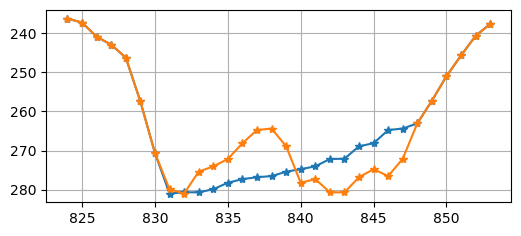

In [96]:
# B. Fix central channel
core[831] = ws_bathy[832, 0] #280.97
core[832] = ws_bathy[843, 0] #280.666
core[833] = ws_bathy[842, 0] #280.658
core[834] = ws_bathy[831, 0] #279.88
core[835] = ws_bathy[840, 0] #278.21
core[836] = ws_bathy[841, 0] #277.3
core[837] = ws_bathy[844, 0] #276.8
core[838] = ws_bathy[846, 0] #276.5
core[839] = ws_bathy[833, 0] #275.4
core[840] = ws_bathy[845, 0] #274.7
core[841] = ws_bathy[834, 0] #274.0
core[842] = ws_bathy[835, 0] #272.2
core[843] = ws_bathy[847, 0] #272.1
core[844] = ws_bathy[839, 0] #268.9
core[845] = ws_bathy[836, 0] #268.1
core[846] = ws_bathy[837, 0] #264.7
core[847] = ws_bathy[838, 0] #264.4
print (core[nis:nie])
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(nis, nie), core[nis:nie], '*-')
ax.plot(np.arange(nis, nie), ws_bathy[nis:nie, 0], '-*')
ax.invert_yaxis();
ax.grid()

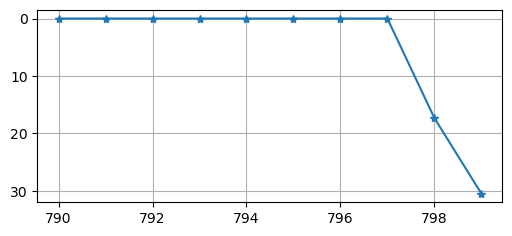

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iss+70, iss+80), core[iss+70:iss+80], '*-')
ax.invert_yaxis();
ax.grid()
# Non-zero starts at 798

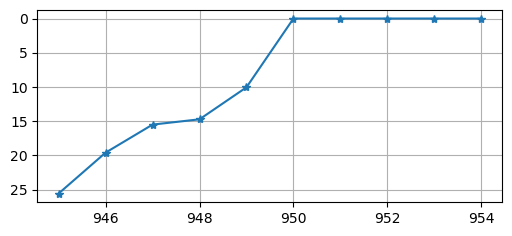

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.plot(np.arange(iee-15, iee-5), core[iee-15:iee-5], '*-')
ax.invert_yaxis();
ax.grid()
# Non-zero starts at 949

In [99]:
nosmooth = core.copy()

In [100]:
# smooth the west profile, twice
newcore = core
for i in range(iss, iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
for i in range(iss, iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
# rezero south part so we do not expand the domain
core[0:798] = 0
# rezero north part so we do not expand the domain
core[950:] = 0

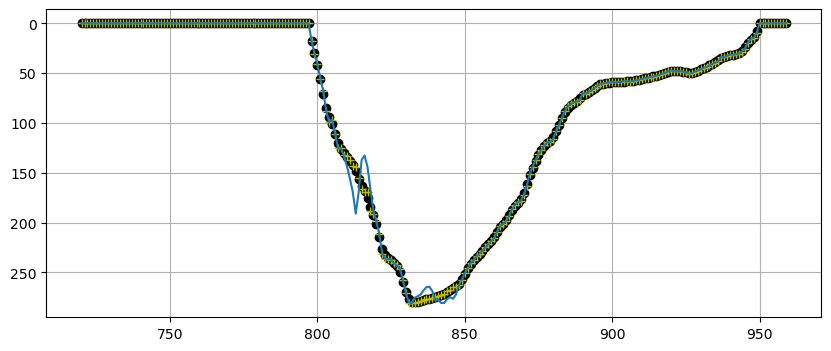

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(iss, iee), core[iss:iee],'ko')
ax.plot(range(iss, iee), nosmooth[iss:iee],'y+')
ax.plot(range(iss, iee), ws_bathy[iss:iee, 0],'-')
ax.invert_yaxis();
#ax.set_xlim(800, 850)
ax.grid()

## Adjust Specific Grid Cells

Adjust the depth of specific grid cells based on the tile by tile comparisons in the `Compare202405-2xrezBathymetry.ipynb` notebook.

The "Tile y, x" titles in this section match those in the comparison notebook.

In [18]:
adj_bathy = ns_masked.copy()

In [19]:
# use single resolution index values because they are more familiar
tile_x_min_max = [
    numpy.array([0, 35]),
    numpy.array([30, 65]),
    numpy.array([60, 95]),
    numpy.array([90, 125]),
    numpy.array([120, 155]),
    numpy.array([150, 185]),
    numpy.array([180, 215]),
    numpy.array([210, 245]),
    numpy.array([240, 275]),
    numpy.array([270, 305]),
    numpy.array([300, 335]),
    numpy.array([330, 365]),
    numpy.array([360, 398]),
]

In [20]:
def to_array_indices(adj_pt, y_min_max, x_min_max):
    dx, dy = adj_pt
    return y_min_max[0] * 2 + dy, x_min_max[0] * 2 + dx

### Row 9 - Juan de Fuca Strait to Bellingham Bay

In [21]:
y_min_max = numpy.array([300, 330])
y_slice = slice(*y_min_max * 2)

#### Tile 9, 5 - Metchosin

* connect island that is really end of William Head

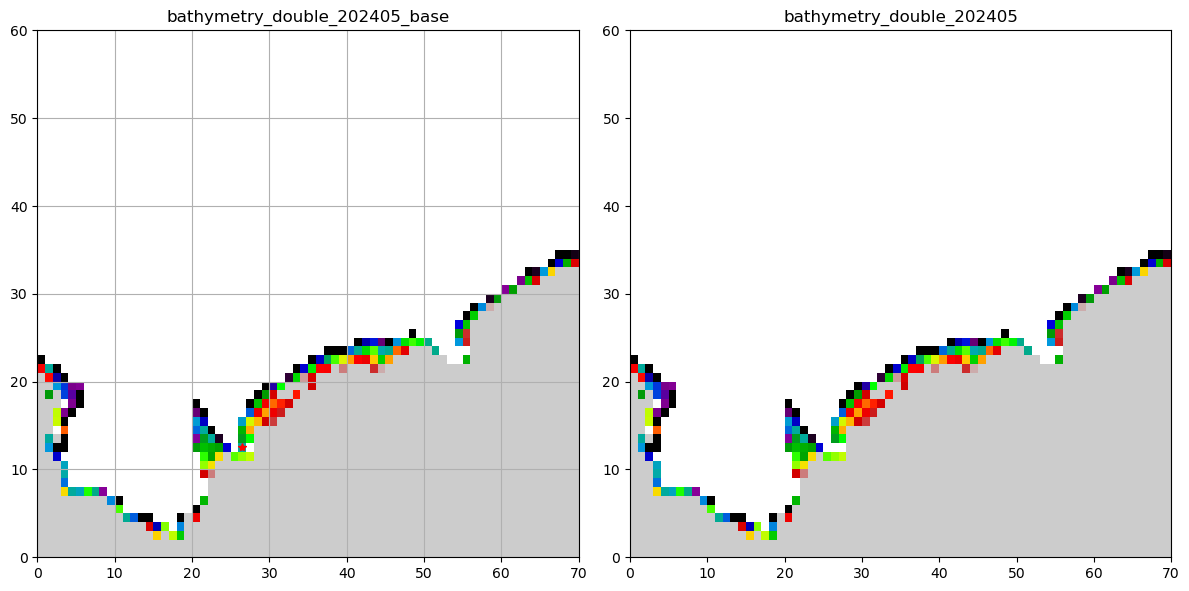

In [22]:
x_min_max = tile_x_min_max[5]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pt = numpy.array([26, 12])  # grid cell x-y to adjust in plot coordinates
ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
adj = to_array_indices(adj_pt, y_min_max, x_min_max)
adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 9, 6 - Esquimalt and Victoria

* connect islands to make Esquimalt Point
* surface Chain Islands

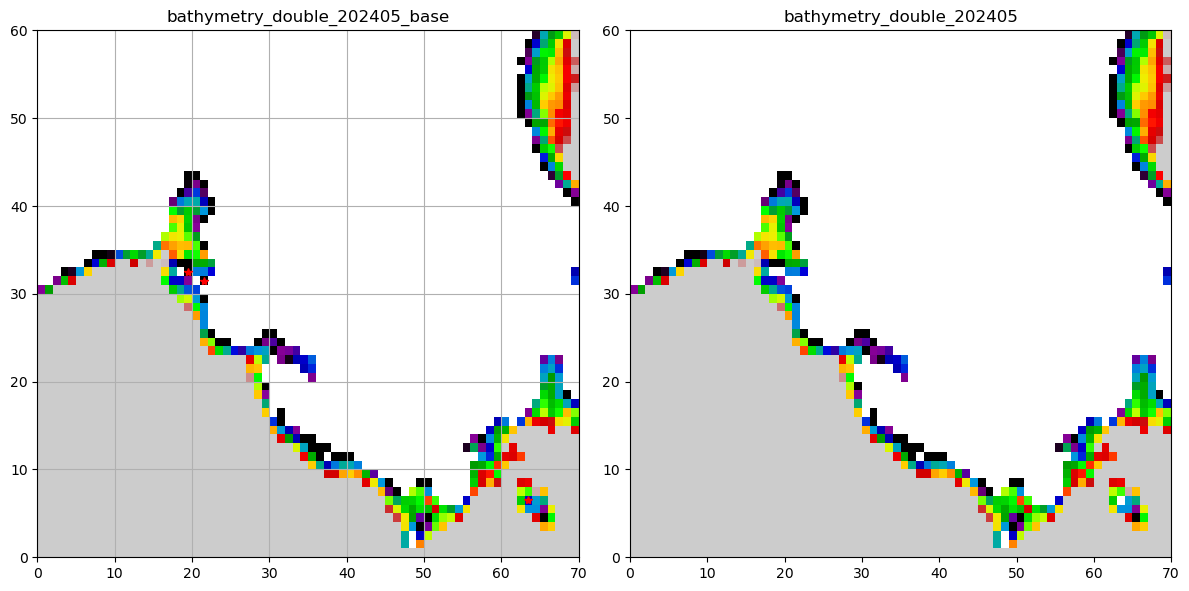

In [23]:
x_min_max = tile_x_min_max[6]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([19, 32]),
    numpy.array([21, 31]),
    numpy.array([63, 6]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 9, 7 - Haro Strait

* fix Discovery Island
* Make east Chatham Island T-shaped

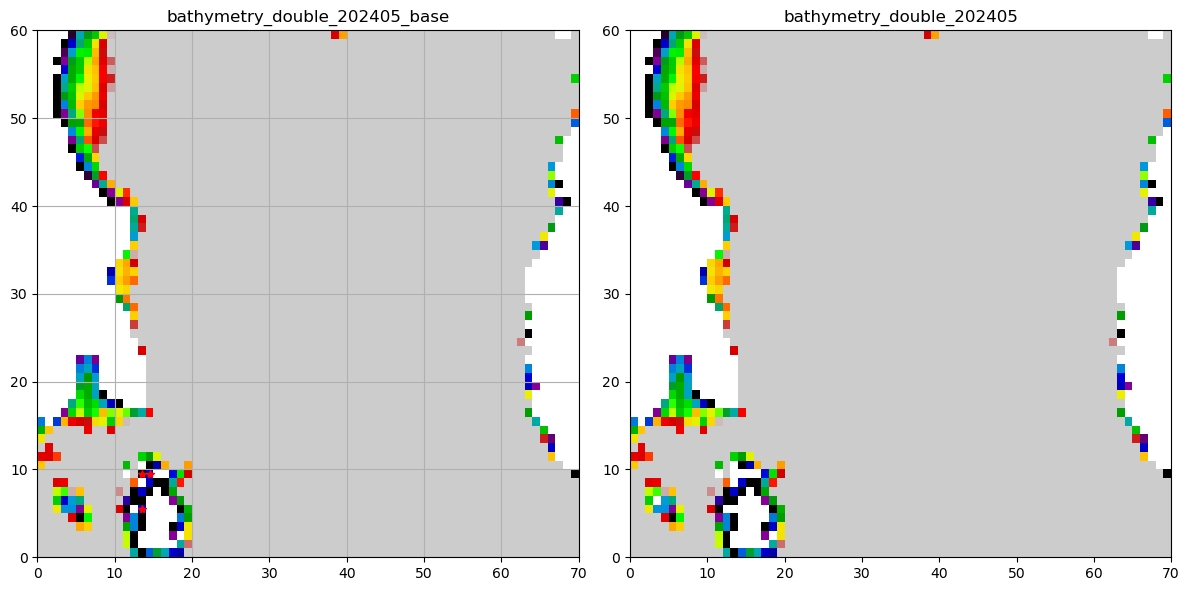

In [24]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([13, 5]),
    numpy.array([13, 9]),
    numpy.array([14, 9]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 10 - Juan de Fuca, Jordan River, Saanich Inlet, boundary islands, Neptune Beach

In [25]:
y_min_max = numpy.array([330, 360])
y_slice = slice(*y_min_max * 2)

#### Tile 10, 3 - Jordan River, French Beach, and Sheringham Point

* Remove extraneous island off French Beach

11.940832455952963
4.616666714350383
4.0
4.0
4.0
4.0
4.0
6.8121209144592285
5.421202510595322


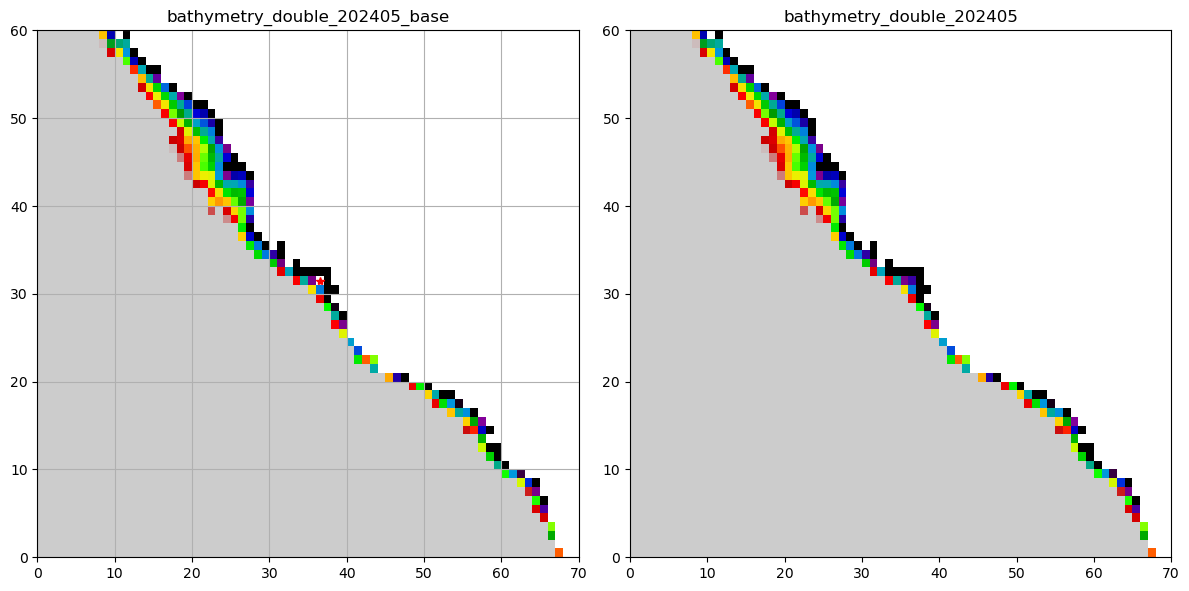

In [26]:
x_min_max = tile_x_min_max[3]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([36, 31]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")
near_pts = [  # gird cell x-y of cells surrounding cell to be adjusted
    numpy.array([35, 30]),
    numpy.array([35, 31]),
    numpy.array([35, 32]),
    numpy.array([36, 32]),
    numpy.array([37, 32]),
    numpy.array([37, 31]),
    numpy.array([37, 30]),
    numpy.array([36, 30]),
]
depth_sum = 0
for near_pt in near_pts:
    adj = to_array_indices(near_pt, y_min_max, x_min_max)
    print(ns_masked[adj])
    depth_sum += ns_masked[adj]
depth_mean = depth_sum / len(near_pts)
print(depth_mean)

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = depth_mean

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 10, 7 - James Island & Sidney Island

* connect spit on north end of Sidney Island
* connect Gooch Island
* Surface Forrest, Demville & Brethour Islands

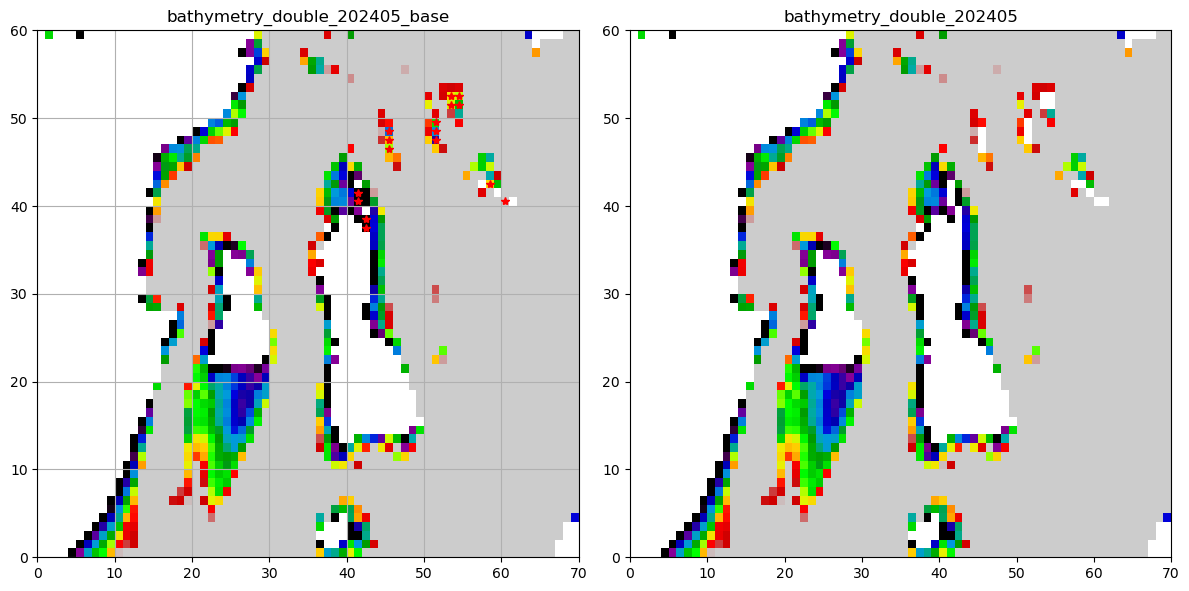

In [27]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Sidney Island spit
    numpy.array([42, 37]),
    numpy.array([42, 38]),
    numpy.array([41, 40]),
    numpy.array([41, 41]),
    # Gooch Island
    numpy.array([58, 42]),
    numpy.array([60, 40]),
    # Forrest Island
    numpy.array([45, 48]),
    numpy.array([45, 47]),
    numpy.array([45, 46]),
    # Forrest Island
    numpy.array([51, 49]),
    numpy.array([51, 48]),
    numpy.array([51, 47]),
    # Brethor Island
    numpy.array([53, 52]),
    numpy.array([53, 51]),
    numpy.array([54, 52]),
    numpy.array([54, 51]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 10, 9 - Waldron Island

* surface Skipjack Island

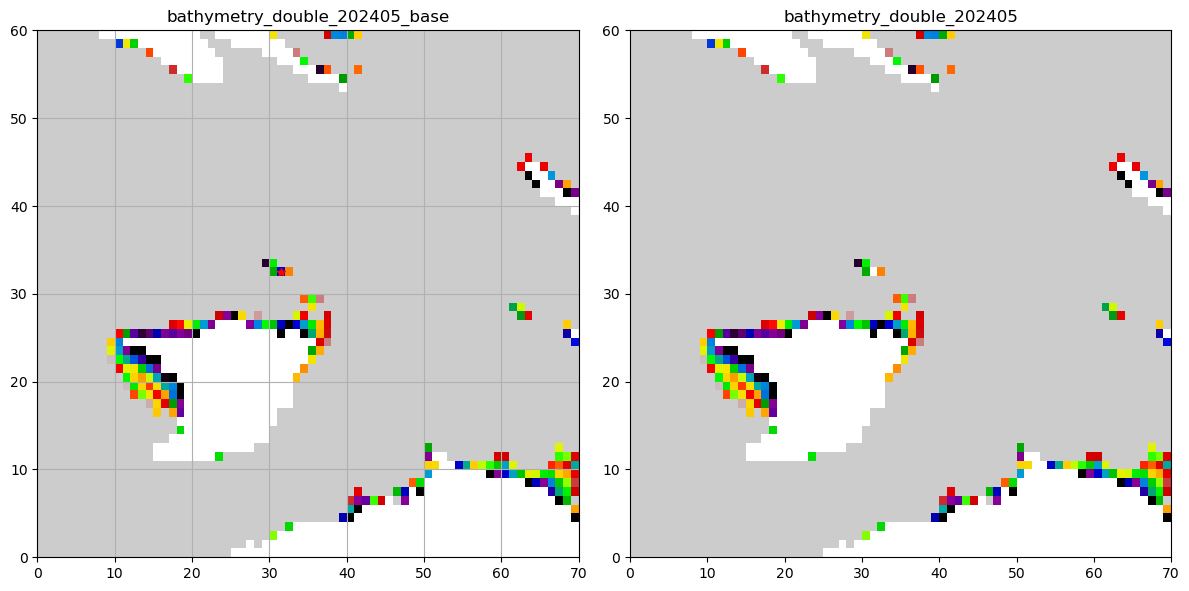

In [28]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([31, 32]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = numpy.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 11 - Neah Bay to Semiahmoo Bay

In [29]:
y_min_max = numpy.array([360, 390])
y_slice = slice(*y_min_max * 2)

#### Tile 11, 7 - Fulford Harbour

* surface Piers Island, Knapp Island & Pym Island

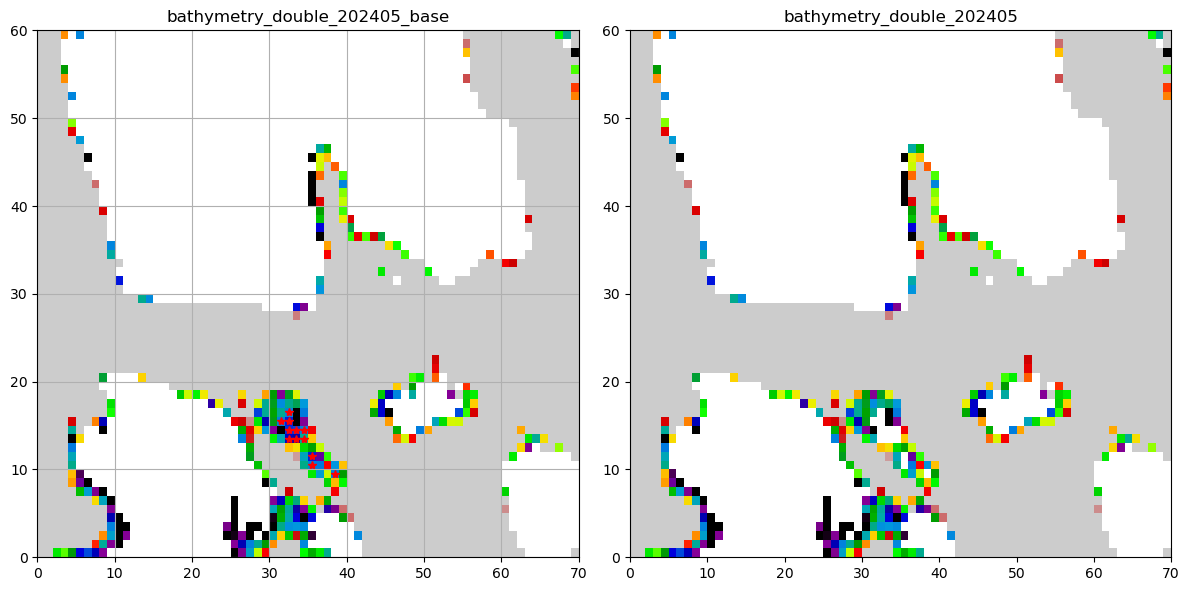

In [30]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Piers Island
    numpy.array([31, 15]),
    numpy.array([32, 16]),
    numpy.array([32, 15]),
    numpy.array([32, 14]),
    numpy.array([32, 13]),
    numpy.array([33, 14]),
    numpy.array([33, 13]),
    numpy.array([34, 14]),
    numpy.array([34, 13]),
    # Knapp Island
    numpy.array([35, 10]),
    numpy.array([35, 11]),
    # Pym Island
    numpy.array([38, 9]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 11, 9 - Saturna Island & Tumbo Island

* surface Tumbo Island
* narrow Boat Passage
* open west entrance to Winter Cove

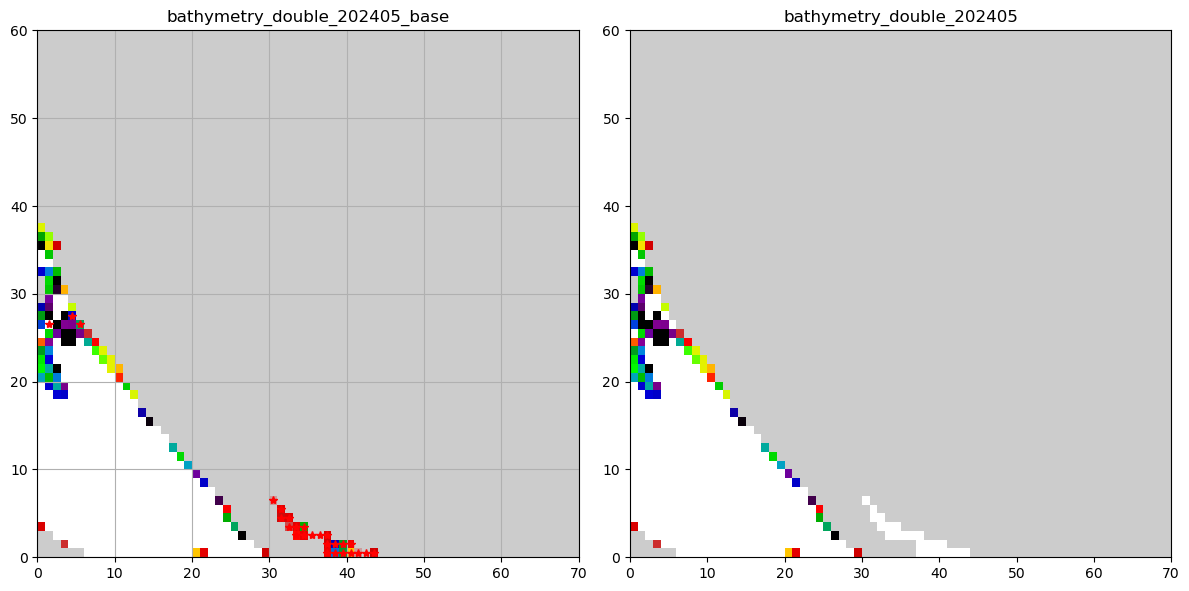

In [44]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Tumbo Island
    numpy.array([30, 6]),
    numpy.array([31, 5]),
    numpy.array([31, 4]),
    numpy.array([32, 4]),
    numpy.array([32, 3]),
    numpy.array([33, 3]),
    numpy.array([33, 2]),
    numpy.array([34, 3]),
    numpy.array([34, 2]),
    numpy.array([35, 2]),
    numpy.array([37, 2]),
    numpy.array([37, 0]),
    numpy.array([37, 1]),
    numpy.array([36, 2]),
    numpy.array([38, 0]),
    numpy.array([38, 1]),
    numpy.array([39, 0]),
    numpy.array([39, 1]),
    numpy.array([40, 0]),
    numpy.array([40, 1]),
    numpy.array([41, 0]),
    numpy.array([42, 0]),
    numpy.array([43, 0]),
    # north side of Boat Passage
    numpy.array([4, 27]),
    numpy.array([5, 26]),
    # west entrance to Winter Cove
    numpy.array([1, 26]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:-1]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan
adj = to_array_indices(adj_pts[-1], y_min_max, x_min_max)
adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

### Row 12 - Neah Bay to Surrey

In [48]:
y_min_max = numpy.array([390, 420])
y_slice = slice(*y_min_max * 2)

#### Tile 12, 7 - Crofton, Ganges, Long Harbour & Trincomali Channel

* fill in Athol Peninsula

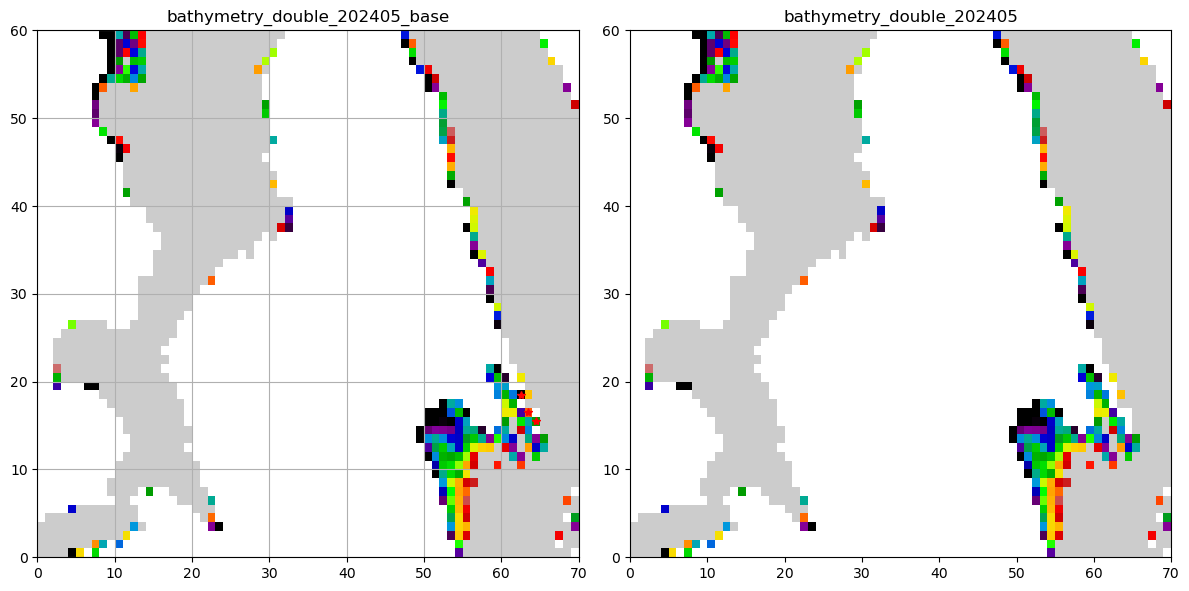

In [58]:
x_min_max = tile_x_min_max[7]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([62, 18]),
    numpy.array([63, 16]),
    numpy.array([64, 15]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 8 - Galiano Island

* separate Parker Island
* connect 2 points on north end of Prevost Island

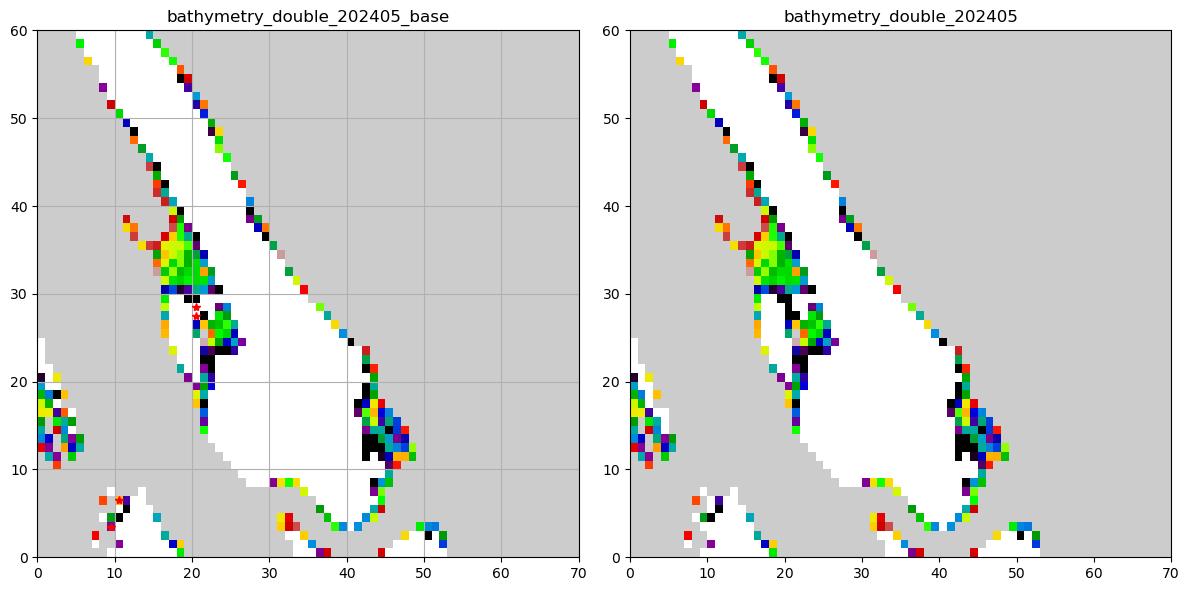

In [62]:
x_min_max = tile_x_min_max[8]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Parker Island separation
    numpy.array([20, 28]),
    numpy.array([20, 27]),
    # north Prevost Island points
    numpy.array([10, 6]),
    numpy.array([9, 3]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:2]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4
for adj_pt in adj_pts[-2:]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 9 - Roberts Bank

* change 4 fake islands to 4m deep

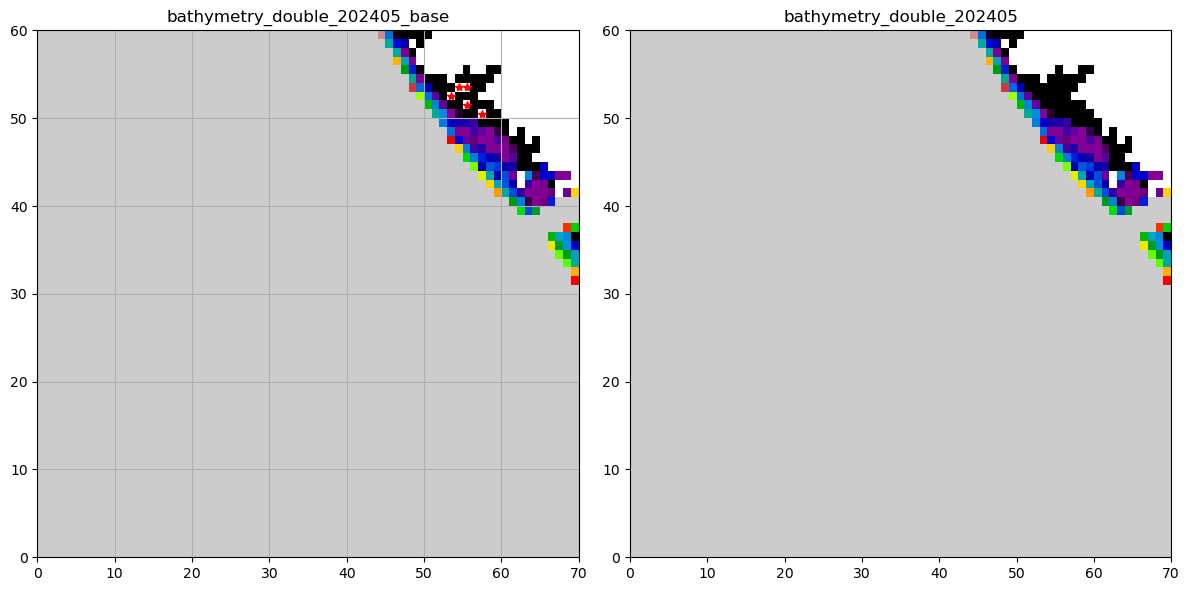

In [69]:
x_min_max = tile_x_min_max[9]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    numpy.array([53, 52]),
    numpy.array([54, 53]),
    numpy.array([55, 53]),
    numpy.array([55, 51]),
    numpy.array([57, 50]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

#### Tile 12, 10 - Point Roberts & Tsawwassen

* add Tsawwassen ferry terminal and spit
* add Roberts Bank port and spit
* change fake island SE of Pt. Roberts to 4m deep

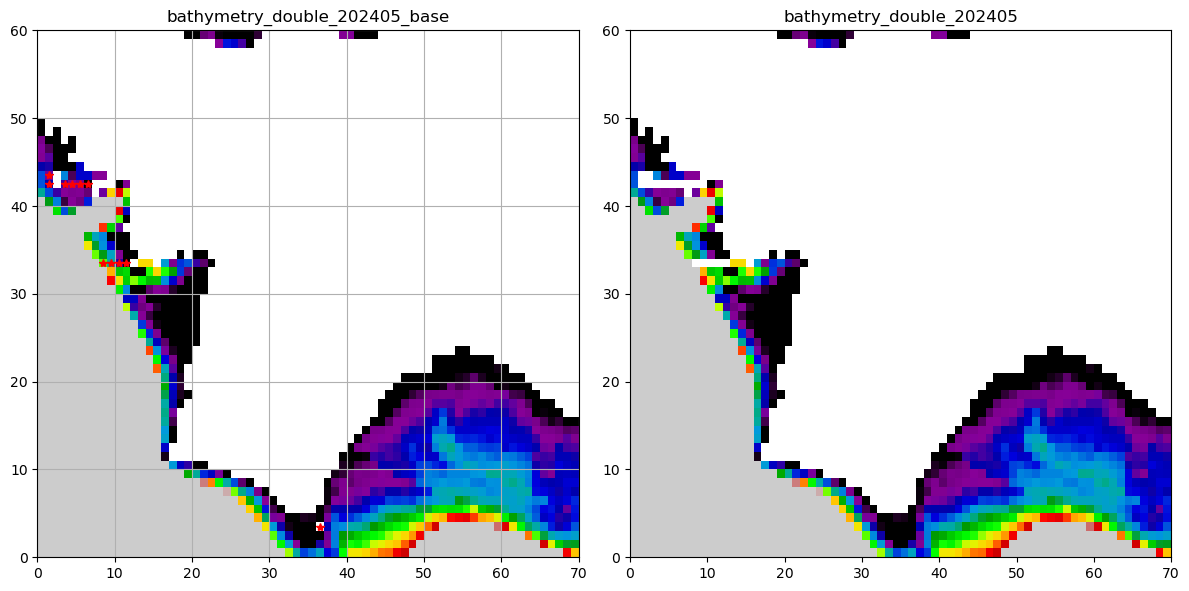

In [79]:
x_min_max = tile_x_min_max[10]
x_slice = slice(*x_min_max * 2)

fig, (ax_base, ax_final) = plt.subplots(1, 2, figsize=(12, 6))

# use spectral colour map to provide lots of contrast between grid cells
cmap = "nipy_spectral"

ax_base.set_title("bathymetry_double_202405_base")
viz_tools.set_aspect(ax_base)
ax_base.pcolormesh(ns_masked[y_slice, x_slice], cmap=cmap, vmax=15)
ax_base.grid(True)

# Mark adjustment
adj_pts = [  # grid cell x-y to adjust in plot coordinates
    # Tsawwassen ferry terminal and spit
    numpy.array([11, 33]),
    numpy.array([10, 33]),
    numpy.array([9, 33]),
    numpy.array([8, 33]),
    # Roberts Bank port and spit
    numpy.array([1, 43]),
    numpy.array([1, 42]),
    numpy.array([3, 42]),
    numpy.array([4, 42]),
    numpy.array([5, 42]),
    numpy.array([6, 42]),
    # fake island SE of Pt. Roberts
    numpy.array([36, 3]),
]
for adj_pt in adj_pts:
    ax_base.plot(*adj_pt+0.5, "r*")

# Do adjustment
for adj_pt in adj_pts[:-1]:
    adj = to_array_indices(adj_pt, y_min_max, x_min_max)
    adj_bathy[adj] = np.nan
adj = to_array_indices(adj_pts[-1], y_min_max, x_min_max)
adj_bathy[adj] = 4

ax_final.set_title("bathymetry_double_202405")
viz_tools.set_aspect(ax_final)
ax_final.pcolormesh(adj_bathy[y_slice, x_slice], cmap=cmap, vmax=15)

fig.tight_layout()

## Smooth the Bathymetry

### **IMPORTANT** Ensure that the correct masked array is passed to `bathy_tools.smooth()` during WIP

In [17]:
sm_bathy = bathy_tools.smooth(adj_bathy, max_norm_depth_diff=0.8, smooth_factor=0.2)

In [18]:
depth_check(sm_bathy)

## Store Finished Bathymetry in a netCDF File

We now have the finished bathymetry.
Store it in a netCDF file.

### **IMPORTANT** Ensure that the correct masked array is copied to `final_bathy` during WIP

In [85]:
final_bathy = adj_bathy

In [86]:
final_dbl_202405_ds = xarray.Dataset(
    data_vars={
        "Bathymetry": xarray.DataArray(
            data=final_bathy,
            dims=["y", "x"],
            attrs={
                "long_name": "sea_floor_depth",
                "units": "m",
            },
        ),
        "nav_lat": xarray.DataArray(
            data=lats,
            dims=["y", "x"],
            attrs={
                "long_name": "latitude",
                "units": "degrees_north",
            },
        ),
        "nav_lon": xarray.DataArray(
            data=lons,
            dims=["y", "x"],
            attrs={
                "long_name": "longitude",
                "units": "degrees_east",
            },
        ),
    },
    coords={
        "y": numpy.arange(final_bathy.shape[0], dtype=int),
        "x": numpy.arange(final_bathy.shape[1], dtype=int),
    },
    attrs={
        "Conventions": "CF-1.6",
        "title": "Bathymetry 202405 Double Resolution",
        "institution": "Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia",
        "source": "Bathymetry processed from analysis-doug/notebooks/2xrez-202111/bathymetry-202405-2xrez.ipynb "
                  "by tools/bathymetry/Process202405-2xrezBathymetry.ipynb",
        "history": f"[{arrow.now():YYYY-MM-DD HH:mm:ss}] Created netCDF4 zlib=True dataset.",
    },
)

final_dbl_202405_ds

<xarray.Dataset> Size: 35MB
Dimensions:     (y: 1816, x: 796)
Coordinates:
  * y           (y) int64 15kB 0 1 2 3 4 5 6 ... 1810 1811 1812 1813 1814 1815
  * x           (x) int64 6kB 0 1 2 3 4 5 6 7 ... 789 790 791 792 793 794 795
Data variables:
    Bathymetry  (y, x) float64 12MB nan nan nan nan nan ... nan nan nan nan nan
    nav_lat     (y, x) float64 12MB 46.84 46.83 46.83 ... 51.11 51.11 51.11
    nav_lon     (y, x) float64 12MB -123.4 -123.4 -123.4 ... -124.3 -124.3
Attributes:
    Conventions:  CF-1.6
    title:        Bathymetry 202405 Double Resolution
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       Bathymetry processed from analysis-doug/notebooks/2xrez-202...
    history:      [2025-03-25 10:00:59] Created netCDF4 zlib=True dataset.

In [88]:
encoding = {
    "Bathymetry": {"zlib": True, "complevel": 4},
    "nav_lat": {"zlib": True, "complevel": 4},
    "nav_lon": {"zlib": True, "complevel": 4},
}
# use `engine="netcdf4"` because it produces a substantially smaller file than `engine="h5netcdf"`
final_dbl_202405_ds.to_netcdf(bathy_paths["dbl_final_202405"], encoding=encoding, engine="netcdf4")